In [3]:
import os, sys, time, glob
import numpy as np
import scipy as sp
import mvpa2.suite as mvpa2

add_delay = 6
TR = 2.3

output_path = 'output'
offset = 5

In [4]:
def read_and_preprocess_picture_data(data_file,mask_file,log_file,nuisance_file,brightness_file,nTRs=2):
    
    ds = mvpa2.fmri_dataset(data_file,mask=mask_file,add_fa={'cluster':mask_file})

    log = np.recfromcsv(log_file,delimiter=',')

    with open(nuisance_file) as f:
        nuisance = f.readlines()
    reg1 = []
    reg2 = []
    for nuisance_line in nuisance:
        a = nuisance_line.split(' ')
        if len(a) == 2:
            reg1.append(float(a[0]))
            reg2.append(float(a[1]))
    
    ds.sa['reg1']=reg1
    ds.sa['reg2']=reg2
    ds.sa['timepoint'] = TR * np.arange(len(ds))
    ds.sa['chunks'] = [0 for i in range(len(ds))]
    
    ## Regress away nuisance regressors (white-matter and background noise)
    ds = ds[offset:]

    opt_regs = ['reg1','reg2']
    mvpa2.poly_detrend(ds,polyord=1,opt_regs=opt_regs)
    mvpa2.zscore(ds,chunks_attr=None)

    ## Select all the scans where the pictures are shown (onset+6s)
    scans = np.round((log.onset + add_delay) / TR).astype(int) - offset

    # First
    ds_extracted = [ds[scans+nTR].copy(deep=True) for nTR in range(nTRs)]
    
    for ds_e in ds_extracted:
        ds_e.sa['chunks'] = log.session
        ds_e.sa['category'] = log.category    
        ds_e.sa['brightness'] = np.log(log.brightness)
    
    for i in range(1,nTRs):
        ds_extracted[0].samples = ds_extracted[0].samples + ds_extracted[i].samples

    mvpa2.poly_detrend(ds_extracted[0],polyord=0,opt_regs=['brightness'])
    
    ds1 = ds_extracted[0]
    ds1 = ds1[np.argsort(log.picture)]
    
    sample_mean = np.mean(ds1,axis=1)
    for i,s in enumerate(sample_mean):
        ds1.samples[i,:] -= s
    
    return ds1

Using raw data

In [26]:
accuracy_results = []

In [29]:
method = 'normalized_common'
method0 = method.split('_')[0]
method1 = method.split('_')[1]

#roi_mask = ['picture_0.5','picture_1','picture_2']
#roi_mask = ['picture_1_no_occip_clust_10']
#roi_mask = ['picture_1_clust_10','picture_2_clust_10','picture_5_clust_10']
roi_mask = ['picture_thresh2']
#roi_mask = ['wholebrain']

for nTR in [1,3]:

    print nTR
    
    for r in roi_mask:
        print r

        accuracy = []

        for subj in range(4,42):

            ## For each subject    
            start_time = time.time()

            data_file = '../nifti/'+method0+'/picture/S'+str(subj)+'_picture_'+method0+'.nii'

            if r == "wholebrain":
                mask_file = '../roi/normalized/cortex-mask.nii.gz'
            elif method1 == "common":
                if method0 == "native":
                    mask_file = '../roi/'+method0+'/common_mask/'+r+'/S'+str(subj)+'/w'+r+'.nii'
                else:
                    mask_file = '../roi/'+method0+'/common_mask/'+r+'.nii'
            else:
                mask_file = '../roi/'+method0+'/'+r+'/S'+str(subj)+'.nii'

            log_file = '../log/S'+str(subj)+'_picture.csv'
            nuisance_file = '../nuisance/S'+str(subj)+'_picture_nuisance.txt'
            brightness_file = '../nuisance/S'+str(subj)+'_picture_brightness.txt'

            ds = read_and_preprocess_picture_data(data_file,mask_file,log_file,nuisance_file,brightness_file,nTR)

            elapsed_time = time.time() - start_time

            clf = mvpa2.LinearCSVMC(space='category')
            cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='chunks'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
            res = cv(ds)

            accuracy.append(np.mean(res))
            print "Subject "+str(subj)+" "+str(ds.shape)+(" Accuracy: %.2f"%np.mean(res))+\
                    " Elapsed time: "+'{:1.2f}'.format(elapsed_time)+'s'

        accuracy = np.array(accuracy)
        mask = (np.arange(4,42) != 8)

        print "Mean = "+str(np.mean(accuracy[mask]))
        print "SD = "+str(np.std(accuracy[mask]))
        print str(sp.stats.ttest_1samp(accuracy[mask],0.25))
        
        accuracy_results.append(accuracy[mask])

1
picture_thresh2
Subject 4 (112, 3173) Accuracy: 0.36 Elapsed time: 0.60s
Subject 5 (112, 3173) Accuracy: 0.34 Elapsed time: 0.55s
Subject 6 (112, 3173) Accuracy: 0.42 Elapsed time: 0.67s
Subject 7 (112, 3173) Accuracy: 0.30 Elapsed time: 0.60s
Subject 8 (112, 3173) Accuracy: 0.29 Elapsed time: 0.58s
Subject 9 (112, 3173) Accuracy: 0.28 Elapsed time: 0.57s
Subject 10 (112, 3173) Accuracy: 0.28 Elapsed time: 0.58s
Subject 11 (112, 3173) Accuracy: 0.31 Elapsed time: 0.59s
Subject 12 (112, 3173) Accuracy: 0.57 Elapsed time: 0.57s
Subject 13 (112, 3173) Accuracy: 0.45 Elapsed time: 0.59s
Subject 14 (112, 3173) Accuracy: 0.49 Elapsed time: 0.59s
Subject 15 (112, 3173) Accuracy: 0.54 Elapsed time: 0.58s
Subject 16 (112, 3173) Accuracy: 0.38 Elapsed time: 0.58s
Subject 17 (112, 3173) Accuracy: 0.43 Elapsed time: 0.59s
Subject 18 (112, 3173) Accuracy: 0.38 Elapsed time: 0.59s
Subject 19 (112, 3173) Accuracy: 0.40 Elapsed time: 0.59s
Subject 20 (112, 3173) Accuracy: 0.35 Elapsed time: 0.62s
Su

Use beta images

In [18]:
accuracy = []
roi_mask = 'picture_thresh2'
picture_beta = 'T3' # ~3TRs

for subj in range(4,42):

    ## For each subject    
    start_time = time.time()

    mask_file = '../roi/normalized/common_mask/'+roi_mask+'.nii'

    ds = mvpa2.fmri_dataset(glob.glob('../spm/normalized/picture/S'+str(subj)+'/'+picture_beta+'/beta*.nii')[:112],mask=mask_file)

    log_file = '../log/S'+str(subj)+'_picture.csv'
    log = np.recfromcsv(log_file,delimiter=',')
    ds.sa['category']=sorted(log.category)
    ds.sa['chunks']=log.session[np.argsort(log.picture)]
    
    elapsed_time = time.time() - start_time

    clf = mvpa2.LinearCSVMC(space='category')
    cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='chunks'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
    res = cv(ds)

    accuracy.append(np.mean(res))
    print "Subject "+str(subj)+" "+str(ds.shape)+(" Accuracy: %.2f"%np.mean(res))+\
            " Elapsed time: "+'{:1.2f}'.format(elapsed_time)+'s'

accuracy = np.array(accuracy)
mask = (np.arange(4,42) != 8)

print "Mean = "+str(np.mean(accuracy[mask]))
print "SD = "+str(np.std(accuracy[mask]))
print str(sp.stats.ttest_1samp(accuracy[mask],0.25))

Subject 4 (112, 3173) Accuracy: 0.54 Elapsed time: 0.74s
Subject 5 (112, 3173) Accuracy: 0.54 Elapsed time: 14.72s
Subject 6 (112, 3173) Accuracy: 0.69 Elapsed time: 8.59s
Subject 7 (112, 3173) Accuracy: 0.48 Elapsed time: 18.52s
Subject 8 (112, 3173) Accuracy: 0.25 Elapsed time: 10.55s
Subject 9 (112, 3173) Accuracy: 0.50 Elapsed time: 7.75s
Subject 10 (112, 3173) Accuracy: 0.45 Elapsed time: 14.21s
Subject 11 (112, 3173) Accuracy: 0.41 Elapsed time: 12.70s
Subject 12 (112, 3173) Accuracy: 0.69 Elapsed time: 7.66s
Subject 13 (112, 3173) Accuracy: 0.57 Elapsed time: 20.27s
Subject 14 (112, 3173) Accuracy: 0.60 Elapsed time: 13.42s
Subject 15 (112, 3173) Accuracy: 0.62 Elapsed time: 10.49s
Subject 16 (112, 3173) Accuracy: 0.51 Elapsed time: 9.14s
Subject 17 (112, 3173) Accuracy: 0.53 Elapsed time: 16.07s
Subject 18 (112, 3173) Accuracy: 0.46 Elapsed time: 8.29s
Subject 19 (112, 3173) Accuracy: 0.48 Elapsed time: 18.08s
Subject 20 (112, 3173) Accuracy: 0.47 Elapsed time: 10.05s
Subject 2

Native space

In [22]:
method = 'native_indiv'
method0 = method.split('_')[0]
method1 = method.split('_')[1]

roi_mask = ['picture_thresh2']

for nTR in [2]:

    print nTR
    
    for r in roi_mask:
        print r

        accuracy = []

        for subj in range(4,42):

            ## For each subject    
            start_time = time.time()

            data_file = '../nifti/'+method0+'/picture/S'+str(subj)+'_picture_'+method0+'.nii'

            if r == "wholebrain":
                mask_file = '../roi/normalized/cortex-mask.nii.gz'
            elif method1 == "common":
                if method0 == "native":
                    mask_file = '../roi/'+method0+'/common_mask/'+r+'/S'+str(subj)+'/w'+r+'.nii'
                else:
                    mask_file = '../roi/'+method0+'/common_mask/'+r+'.nii'
            else:
                mask_file = '../roi/'+method0+'/'+r+'/S'+str(subj)+'.nii'

            log_file = '../log/S'+str(subj)+'_picture.csv'
            nuisance_file = '../nuisance/S'+str(subj)+'_picture_nuisance.txt'
            brightness_file = '../nuisance/S'+str(subj)+'_picture_brightness.txt'

            ds = read_and_preprocess_picture_data(data_file,mask_file,log_file,nuisance_file,brightness_file,nTR)

            elapsed_time = time.time() - start_time

            clf = mvpa2.LinearCSVMC(space='category')
            cv = mvpa2.CrossValidation(clf, mvpa2.NFoldPartitioner(attr='chunks'),errorfx=mvpa2.mean_match_accuracy,enable_ca=['stats'])
            res = cv(ds)

            accuracy.append(np.mean(res))
            print "Subject "+str(subj)+" "+str(ds.shape)+(" Accuracy: %.2f"%np.mean(res))+\
                    " Elapsed time: "+'{:1.2f}'.format(elapsed_time)+'s'

        accuracy = np.array(accuracy)
        mask = (np.arange(4,42) != 8)

        print "Mean = "+str(np.mean(accuracy[mask]))
        print "SD = "+str(np.std(accuracy[mask]))
        print str(sp.stats.ttest_1samp(accuracy[mask],0.25))

2
picture_thresh2
Subject 4 (112, 4977) Accuracy: 0.49 Elapsed time: 1.48s
Subject 5 (112, 5250) Accuracy: 0.43 Elapsed time: 5.66s
Subject 6 (112, 4889) Accuracy: 0.52 Elapsed time: 6.67s
Subject 7 (112, 4372) Accuracy: 0.37 Elapsed time: 6.96s
Subject 8 (112, 4216) Accuracy: 0.34 Elapsed time: 6.24s
Subject 9 (112, 4008) Accuracy: 0.42 Elapsed time: 7.34s
Subject 10 (112, 4307) Accuracy: 0.39 Elapsed time: 6.21s
Subject 11 (112, 4605) Accuracy: 0.29 Elapsed time: 6.09s
Subject 12 (112, 4553) Accuracy: 0.64 Elapsed time: 5.78s
Subject 13 (112, 4481) Accuracy: 0.53 Elapsed time: 6.84s
Subject 14 (112, 4301) Accuracy: 0.53 Elapsed time: 5.65s
Subject 15 (112, 4555) Accuracy: 0.66 Elapsed time: 6.08s
Subject 16 (112, 5066) Accuracy: 0.44 Elapsed time: 6.50s
Subject 17 (112, 4633) Accuracy: 0.52 Elapsed time: 6.13s
Subject 18 (112, 4821) Accuracy: 0.37 Elapsed time: 5.91s
Subject 19 (112, 3899) Accuracy: 0.46 Elapsed time: 6.87s
Subject 20 (112, 4253) Accuracy: 0.40 Elapsed time: 6.98s
Su

In [55]:
sp.stats.ttest_1samp(accuracy_results[1],0.25)

Ttest_1sampResult(statistic=14.567652014841155, pvalue=1.1464999214832307e-16)

## Supplementary Analysis 2

In [31]:
# wholebrain 
print sp.stats.ttest_rel(accuracy_results[0],accuracy_results[1])
# 0.5 
print sp.stats.ttest_rel(accuracy_results[2],accuracy_results[1])
# 2.5 
print sp.stats.ttest_rel(accuracy_results[3],accuracy_results[1])
# 1TR
print sp.stats.ttest_rel(accuracy_results[4],accuracy_results[1])
# 3TR
print sp.stats.ttest_rel(accuracy_results[5],accuracy_results[1])

Ttest_relResult(statistic=-16.597490863226852, pvalue=1.8956001279962862e-18)
Ttest_relResult(statistic=1.6164284347566118, pvalue=0.11473256975782564)
Ttest_relResult(statistic=-4.4550573592327538, pvalue=7.8344129968296441e-05)
Ttest_relResult(statistic=-8.6774985534618843, pvalue=2.3818647235888494e-10)
Ttest_relResult(statistic=-1.9501793550989182, pvalue=0.058974910657793839)


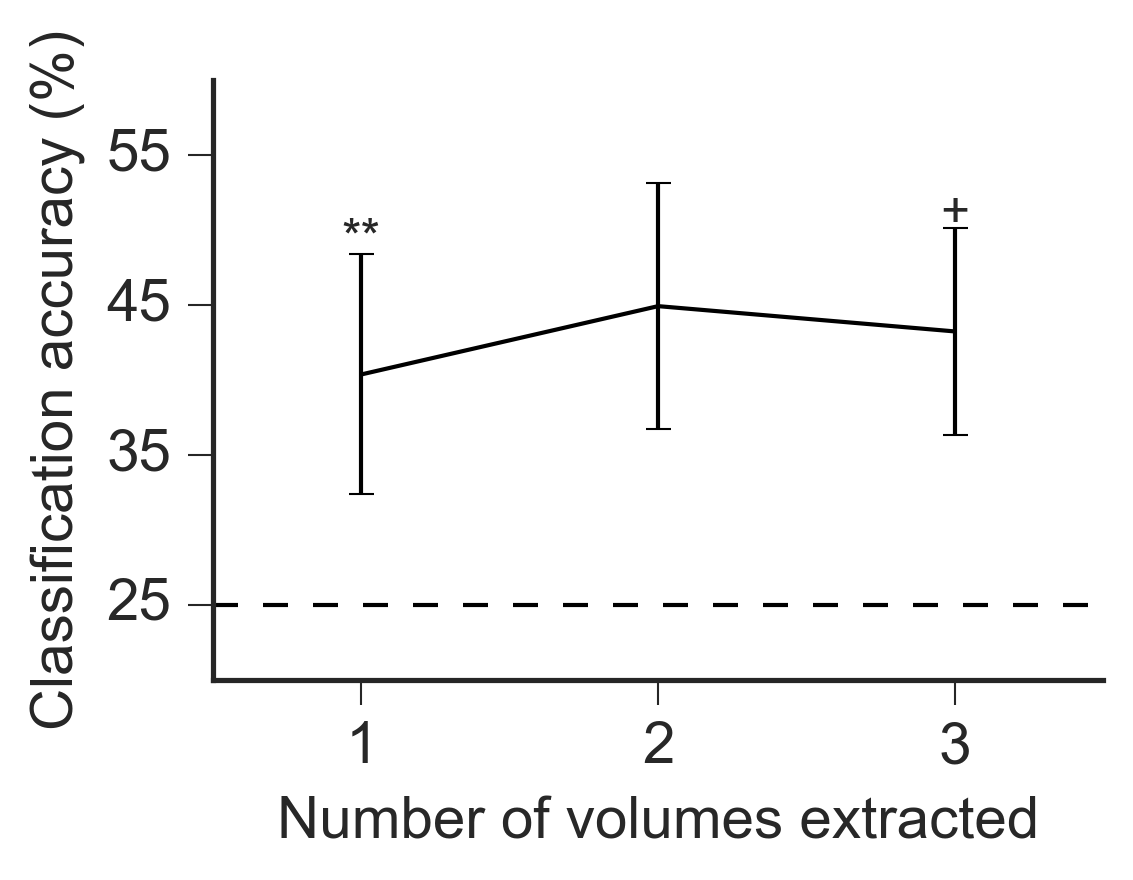

In [54]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

import matplotlib
matplotlib.rc('text', usetex = True)

sns.reset_orig()
sns.set_style("ticks")
plt.rc('font', family='Arial', size=14)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)
sns.set_palette([(0.5,0.5,0.5),(0,0,0)],n_colors=1,desat=0.0)

# whole, 0.5%, 1%, 2.5%
#accuracy = [0.329633204633, 0.455598455598, 0.449324324324, 0.427606177606]
#SD = [0.0792740820055, 0.0778232655412, 0.0820959990483, 0.0778591736153]

# 1TR, 2TR, 3TR
accuracy = [0.403716216216, 0.449324324324, 0.432432432432]
SD = [0.080132545821, 0.0820959990483, 0.0691149349033]

accuracy = np.array(accuracy)*100
SD = np.array(SD)*100

plt.figure(figsize=(4,3))
#plt.errorbar([1,2,3,4], accuracy, yerr=SD, color='k')
#plt.xticks([1,2,3,4])
plt.errorbar([1,2,3], accuracy, yerr=SD, color='k')
plt.xticks([1,2,3])

plt.xlim([0.5,3.5])
plt.ylim([20,60])
plt.yticks([25,35,45,55])

#plt.annotate('**',xy=(1,accuracy[0]+SD[0]),fontsize=12,horizontalalignment='center')
#plt.annotate('${n.s.}$',xy=(2,accuracy[1]+SD[1]+1),fontsize=12,horizontalalignment='center')
#plt.annotate('**',xy=(4,accuracy[3]+SD[3]),fontsize=12,horizontalalignment='center')

plt.annotate('**',xy=(1,accuracy[0]+SD[0]),fontsize=12,horizontalalignment='center')
plt.annotate('+',xy=(3,accuracy[2]+SD[2]),fontsize=12,horizontalalignment='center')

plt.tick_params(top='off', right='off')
plt.axes().spines['right'].set_visible(False)
plt.axes().spines['top'].set_visible(False)
plt.ylabel('Classification accuracy (%)')
#plt.xlabel('Number of voxels')
plt.xlabel('Number of volumes extracted')
plt.plot([0.5,4.5],[25,25],'k--')
plt.tight_layout()
plt.savefig('number_of_TR.pdf',fmt='pdf')
#plt.savefig('number_of_voxel.pdf',fmt='pdf')
plt.show()